
# <font color='green'>sentiment Analysis</font> ![title](./resources/img/sent_twitter.png)

## <font color='red'>Reading Data</font>
***

#### Import liberies

Refer to the web pages for individual libraries
* [Pandas](http://pandas.pydata.org/), to load and manage data
* [Matplotlib](http://matplotlib.org/), for visualization
* [numpy](http://www.numpy.org/) for painting representation and manipulation
* [re](https://docs.python.org/3/library/re.html) for regular expression
* [nltk](http://www.nltk.org/) for pretreatment

In [1]:
import pandas as pd
import re
import os
from copy import copy
import collections
import scipy
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.svm import SVC
from sklearn import model_selection

%matplotlib inline

#### Reading the dataset
Some of the data "downloaded_cleansed_B" is produced out of the "downloaded_cleansed_A". The difference is:
- "downloaded_cleansed_A" has three columns that we won't use.
- "downloaded_cleansed_A" has repeatted tweets.

In [2]:
df = pd.read_csv('./data/train/downloaded_cleansed_B.tsv', sep= '\t', header=None)
print (df.shape)
df.head()

(9665, 4)


,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,Not Available
2,262163168678248449,35266263,negative,Not Available
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,Not Available


Note that some tweets are "Not Available". We will reject them because it will not help in the analysis of feelings

#### Supprimer tous les tweets "NOT AVAILABLE"

In [3]:
df = df[df[3] != "Not Available"]
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [4]:
df.shape

(7205, 4)

#### <font color='blue'>Training tweets are too limited: just 7205 tweets ...</font>

In [5]:
raw_tweets = list(df[3])
labels = df[2]

In [6]:
start = 0
end = 50
for tweet in raw_tweets[start:end]:
    print (tweet)
    print ('\n')

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)


with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.


Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.


They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll


Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched


Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://t.co/X49ZEOsG


@oluoch @victor_otti @kunjand I just watched it! Sridevi's comeback.... U remember her from the 90s?? Sun mornings on NTA ;)


#Livewire Nadal confirmed for Mexic

***
## <font color='red'>Pre-train the tweets</font>
https://nlp.stanford.edu/IR-book/html/htmledition/determining-the-vocabulary-of-terms-1.html
***

In [7]:
TT = TweetTokenizer()

def emoticondictionary(filename):
    """
    Reads the emoticon file and represents it as dictionary where the emoticon is the key, 
    and its indication as a value
    """
    emo_scores = {'Positive': 'positive', 'Extremely-Positive': 'positive', 
                  'Negative': 'negative','Extremely-Negative': 'negative',
                  'Neutral': 'neutral'}
    emo_score_list = {}
    fi = open(filename,"r")
    l = fi.readline()
    while l:
        #replace the "Non-break space" with the ordinary space " "
        l = l.replace("\xa0"," ")
        li = l.split(" ")
        l2 = li[:-1] #removes the polarity of the emoticon ('negative', 'positive')
        l2.append(li[len(li) - 1].split("\t")[0]) #gets the last emoticon attached to the polarity by '\t'
        sentiment=li[len(li) - 1].split("\t")[1][:-1] #gets only the polarity, and removes '\n'
        score=emo_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            emo_score_list[l2[i]]=l2[len(l2)-1]
        l=fi.readline()
    return emo_score_list

emoticon_dict = emoticondictionary('./resources/emoticon.txt')


# substititue emoticon with its associated sentiment
def subsEmoticon(tweet,d):
    l = TT.tokenize(tweet)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

raw_tweets = [subsEmoticon(tweet, emoticon_dict) for tweet in raw_tweets]
# print(":D X3 :|")
# subsEmoticon(":D X3 :|", dict)

In [8]:
start = 0
end = 50
for tweet in raw_tweets[start:end]:
    print (tweet)
    print ('\n')

['Gas', 'by', 'my', 'house', 'hit', '$', '3.39', '!', '!', '!', "I'm", 'going', 'to', 'Chapel', 'Hill', 'on', 'Sat', '.', 'positive']


['Iranian', 'general', 'says', "Israel's", 'Iron', 'Dome', "can't", 'deal', 'with', 'their', 'missiles', '(', 'keep', 'talking', 'like', 'that', 'and', 'we', 'may', 'end', 'up', 'finding', 'out', ')']


['with', 'J', 'Davlar', '11th', '.', 'Main', 'rivals', 'are', 'team', 'Poland', '.', 'Hopefully', 'we', 'an', 'make', 'it', 'a', 'successful', 'end', 'to', 'a', 'tough', 'week', 'of', 'training', 'tomorrow', '.']


['Talking', 'about', "ACT's", '&', '&', "SAT's", ',', 'deciding', 'where', 'I', 'want', 'to', 'go', 'to', 'college', ',', 'applying', 'to', 'colleges', 'and', 'everything', 'about', 'college', 'stresses', 'me', 'out', '.']


['They', 'may', 'have', 'a', 'SuperBowl', 'in', 'Dallas', ',', 'but', 'Dallas', "ain't", 'winning', 'a', 'SuperBowl', '.', 'Not', 'with', 'that', 'quarterback', 'and', 'owner', '.', '@S4NYC', '@RasmussenPoll']


['Im', 'b

In [9]:
def correct_case(prev_word, words):
    """
    Gets the proper 'prev_word' case and preserves it with the 'word'.
    """
    def case_of(text):
        """
        Return the case-function appropriate for the given word. 
        The returned cast is [upper, lower, title, or just str].
        """
        if len(text) == 1:
            return str.title if text.isupper() else str.lower
        return (str.upper if text.isupper() else
                str.lower if text.islower() else
                str.title if text.istitle() else
                str)
    assert type(words) == list
    words[0] = case_of(prev_word)(words[0])
    return words

In [10]:
def loadSlangs(filename):
    """
    This function reads the file that contains the slangs, and put them in a dictionary such that
    the key is the "slang" and the value is the acronym.
    slangs["i've"] = ['i',  'have']
    slang['12be'] = ['want', 'to', 'be']
    ...
    CAUTION: the keys and values are in lower-case
    """
    slangs={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            slangs[l[0].lower()]=l[1][:-1].lower().split()
        line=fi.readline()
    fi.close()
    return slangs


replaced = 0
def replaceSlangs(tweet, slangs):
    """
    This function is used to replace the slang in the original tweets and replace them with the acronym.
    And it's also returns the the tweet in lower-case letters
    """
    global replaced
    result = []
    for w in tweet:
        if w.lower() in slangs.keys():
            replaced += 1
            result.extend(correct_case(w, slangs[w.lower()]))
        else:
            result.append(w)
    return result


slangs = loadSlangs('./resources/internetSlangs.txt')
raw_tweets = [replaceSlangs(tweet, slangs) for tweet in raw_tweets]
print (str(replaced)+" words were replaced")

3488 words were replaced


In [11]:
start = 0
end = 50
for tweet in raw_tweets[start:end]:
    print (tweet)
    print ('\n')

['Gas', 'by', 'my', 'house', 'hit', '$', '3.39', '!', '!', '!', "I'm", 'going', 'to', 'Chapel', 'Hill', 'on', 'Sat', '.', 'positive']


['Iranian', 'general', 'says', "Israel's", 'Iron', 'Dome', "can't", 'deal', 'with', 'their', 'missiles', '(', 'keep', 'talking', 'like', 'that', 'and', 'we', 'may', 'end', 'up', 'finding', 'out', ')']


['with', 'J', 'Davlar', '11th', '.', 'Main', 'rivals', 'are', 'team', 'Poland', '.', 'Hopefully', 'we', 'an', 'make', 'it', 'a', 'successful', 'end', 'to', 'a', 'tough', 'week', 'of', 'training', 'tomorrow', '.']


['Talking', 'about', "ACT's", '&', '&', "SAT's", ',', 'deciding', 'where', 'I', 'want', 'to', 'go', 'to', 'college', ',', 'applying', 'to', 'colleges', 'and', 'everything', 'about', 'college', 'stresses', 'me', 'out', '.']


['They', 'may', 'have', 'a', 'SuperBowl', 'in', 'Dallas', ',', 'but', 'Dallas', 'am', 'not', 'winning', 'a', 'SuperBowl', '.', 'Not', 'with', 'that', 'quarterback', 'and', 'owner', '.', '@S4NYC', '@RasmussenPoll']


['Ins

In [12]:
def load_apostrophe_words(filename):
    """
    This function reads the file that contains all words that have apostrophe, and put them in a dictionary 
    such that the key is the "word containing apostrophe" and the value is the "the word without apostrophe".
    slangs['i've'] = 'i have'
    slang['I'm] = 'I am'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    apo={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            apo[l[0].lower()] = l[1][:-1].lower().split()
        line=fi.readline()
    fi.close()
    return apo

replaced = 0
def replace_apostrophe(tweet,apos):
    global replaced
    result = []
    for w in tweet:
        if w.lower() in apos.keys():
            result.extend(correct_case(w, apos[w.lower()]))
            replaced += 1
        else:
            result.append(w)
    return result

apos = load_apostrophe_words('./resources/apostrophe_words.txt')
raw_tweets = [replace_apostrophe(tweet, apos) for tweet in raw_tweets]
print (str(replaced)+" words were replaced")

1682 words were replaced


In [13]:
start = 0
end = 50
for tweet in raw_tweets[start:end]:
    print (tweet)
    print ('\n')

['Gas', 'by', 'my', 'house', 'hit', '$', '3.39', '!', '!', '!', 'i', 'am', 'going', 'to', 'Chapel', 'Hill', 'on', 'Sat', '.', 'positive']


['Iranian', 'general', 'says', "Israel's", 'Iron', 'Dome', 'can', 'not', 'deal', 'with', 'their', 'missiles', '(', 'keep', 'talking', 'like', 'that', 'and', 'we', 'may', 'end', 'up', 'finding', 'out', ')']


['with', 'J', 'Davlar', '11th', '.', 'Main', 'rivals', 'are', 'team', 'Poland', '.', 'Hopefully', 'we', 'an', 'make', 'it', 'a', 'successful', 'end', 'to', 'a', 'tough', 'week', 'of', 'training', 'tomorrow', '.']


['Talking', 'about', "ACT's", '&', '&', "SAT's", ',', 'deciding', 'where', 'I', 'want', 'to', 'go', 'to', 'college', ',', 'applying', 'to', 'colleges', 'and', 'everything', 'about', 'college', 'stresses', 'me', 'out', '.']


['They', 'may', 'have', 'a', 'SuperBowl', 'in', 'Dallas', ',', 'but', 'Dallas', 'am', 'not', 'winning', 'a', 'SuperBowl', '.', 'Not', 'with', 'that', 'quarterback', 'and', 'owner', '.', '@S4NYC', '@RasmussenPoll'

In [14]:
negation_words = set(['barely', 'hardly', 'lack', 'never', 'neither', 'no', 'nobody', \
                      'not', 'nothing', 'none', 'nowhere', 'shortage', 'scarcely'])
punctuations = [',', '.', ':', ';', '!', '?']

def handle_negation(tweet):
    output = []
    negate = False
    for word in tweet:
        if word[-1] in punctuations and negate:
            negate = False
        if negate and not word.lower() in negation_words:
            output.append(word+"_not")
        else:
            output.append(word)
        if word.lower() in negation_words and not negate:
            negate = True
        elif word.lower() in negation_words and negate:
            negate = False
    return output

raw_tweets = [handle_negation(tweet) for tweet in raw_tweets]

In [15]:
start = 0
end = 50
for tweet in raw_tweets[start:end]:
    print (tweet)
    print ('\n')

['Gas', 'by', 'my', 'house', 'hit', '$', '3.39', '!', '!', '!', 'i', 'am', 'going', 'to', 'Chapel', 'Hill', 'on', 'Sat', '.', 'positive']


['Iranian', 'general', 'says', "Israel's", 'Iron', 'Dome', 'can', 'not', 'deal_not', 'with_not', 'their_not', 'missiles_not', '(_not', 'keep_not', 'talking_not', 'like_not', 'that_not', 'and_not', 'we_not', 'may_not', 'end_not', 'up_not', 'finding_not', 'out_not', ')_not']


['with', 'J', 'Davlar', '11th', '.', 'Main', 'rivals', 'are', 'team', 'Poland', '.', 'Hopefully', 'we', 'an', 'make', 'it', 'a', 'successful', 'end', 'to', 'a', 'tough', 'week', 'of', 'training', 'tomorrow', '.']


['Talking', 'about', "ACT's", '&', '&', "SAT's", ',', 'deciding', 'where', 'I', 'want', 'to', 'go', 'to', 'college', ',', 'applying', 'to', 'colleges', 'and', 'everything', 'about', 'college', 'stresses', 'me', 'out', '.']


['They', 'may', 'have', 'a', 'SuperBowl', 'in', 'Dallas', ',', 'but', 'Dallas', 'am', 'not', 'winning_not', 'a_not', 'SuperBowl_not', '.', 'Not'

In [16]:
def preprocess(tweet):
    tweet = ' '.join(tweet) #change from 'list' to str
    # delete symbols and URIs and tags (keep # and _)
    tweet =  ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z_#' \t])|(\w+:\/\/\S+)", '', tweet).split())
    # Convert '@username' to 'at_user'
    # tweet = re.sub('@[^\s]+','at_user',tweet)
    # remove hashtags
    # tweet = re.sub(r'#\s', '', tweet)
    # remove numbers
    tweet = re.sub('[0-9]', '', tweet)
    # remove additional spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # replace the occurrence of 2 or more characters in a word, eg. loooong -> loong
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    return tweet

preprocessed_tweets = [preprocess(tweet) for tweet in raw_tweets]
print (len(preprocessed_tweets))

7205


In [17]:
start = 0
end = 50
for tweet in preprocessed_tweets[start:end]:
    print (tweet)
    print ('\n')

Gas by my house hit i am going to Chapel Hill on Sat positive


Iranian general says Israel's Iron Dome can not deal_not with_not their_not missiles_not _not keep_not talking_not like_not that_not and_not we_not may_not end_not up_not finding_not out_not _not


with J Davlar th Main rivals are team Poland Hopefully we an make it a successful end to a tough week of training tomorrow


Talking about ACT's SAT's deciding where I want to go to college applying to colleges and everything about college stresses me out


They may have a SuperBowl in Dallas but Dallas am not winning_not a_not SuperBowl_not Not with_not that_not quarterback_not and_not owner_not


Instant message bringing the monster load of candy tomorrow I just hope it does not get_not all_not squiched_not


Apple software retail chiefs out in overhaul SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads


I just watched it Sridevi's comeback You remember her from the s Sun mornings on NTA positive


#Livewire Na

#### Delete stopwords
https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

In [18]:
stop_words = stopwords.words('english')
stop_words.extend([word+'_not' for word in stop_words]) #negation
stop_words = set(stop_words)
# stop_words.update('j', 'im')
print (len(stop_words))

# remove stopwords
def rem_stop(tweet):
    words = tweet.split()
    tweet = ' '.join([word for word in words if word.lower() not in stop_words])
    return tweet

final_tweets = [rem_stop(tweet) for tweet in preprocessed_tweets]
del raw_tweets, preprocessed_tweets

print("\nCompare tweets before / after")
df['final_tweets'] = final_tweets
df[[3, 'final_tweets']].head(10)

358

Compare tweets before / after


,3,final_tweets
0,Gas by my house hit $3.39!!!! I'm going to Cha...,Gas house hit going Chapel Hill Sat positive
3,Iranian general says Israel's Iron Dome can't ...,Iranian general says Israel's Iron Dome deal_n...
6,with J Davlar 11th. Main rivals are team Polan...,J Davlar th Main rivals team Poland Hopefully ...
7,"Talking about ACT's &amp;&amp; SAT's, deciding...",Talking ACT's SAT's deciding want go college a...
9,"They may have a SuperBowl in Dallas, but Dalla...",may SuperBowl Dallas Dallas winning_not SuperB...
10,Im bringing the monster load of candy tomorrow...,Instant message bringing monster load candy to...
11,"Apple software, retail chiefs out in overhaul:...",Apple software retail chiefs overhaul SAN FRAN...
12,@oluoch @victor_otti @kunjand I just watched i...,watched Sridevi's comeback remember Sun mornin...
14,#Livewire Nadal confirmed for Mexican Open in ...,#Livewire Nadal confirmed Mexican Open Februar...
15,@MsSheLahY I didnt want to just pop up... but ...,didnt want pop yep chapel hill next wednesday ...


***
## <font color='red'>Lexicon Classification</font>
***

#### Using MPQA Lexicon

These are the very first and last entries of the file 'mpqa.txt'
- abandoned priorpolarity=negative
- abandonment priorpolarity=negative
- abandon priorpolarity=negative
- abase priorpolarity=negative
- abasement priorpolarity=negative
- ...
- zealot priorpolarity=negative
- zealous priorpolarity=negative
- zealously priorpolarity=negative
- zenith priorpolarity=positive
- zest priorpolarity=positive

In [19]:
def MPQAdictionary(filename):
    """
    reads mpqa file which contains the polarity of some of the english words. e.g. 'love': 'positive'
    """
    MPQA_scores = {'priorpolarity=positive\n': 'positive','priorpolarity=negative\n': 'negative',
                  'priorpolarity=neutral\n': 'neutral', 'priorpolarity=both\n': 'neutral'}
    MPQA_score_list = {}
    fi = open(filename,"r")
    line = fi.readline()
    while line: 
        li = line.split(" ")
        l2 = li[:-1] # the word as a list
        sentiment=li[1] #the word's polarity
        score=MPQA_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            MPQA_score_list[l2[i]]=l2[-1]
            # negation
            if l2[-1] == 'positive':
                MPQA_score_list[l2[i]+'_not']='positive' 
            else:
                MPQA_score_list[l2[i]+'_not']='negative' 
        line=fi.readline()
    return MPQA_score_list


def subsMPQA(tweet,d):
    l = TT.tokenize(tweet)
    #print(l)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

dictionary = MPQAdictionary('./resources/mpqa/mpqa.txt')
print ("Number of MPQA words: %d" % len(dictionary.keys()))
raw_tweets_MPQA = [subsMPQA(tweet, dictionary) for tweet in final_tweets]

print (subsMPQA(final_tweets[7], dictionary))
# watched sridevis comeback remember sun morning nta positive
subsMPQA("surprise happy abandoned", dictionary)

Number of MPQA words: 13772
['watched', "Sridevi's", 'positive', 'remember', 'Sun', 'mornings', 'NTA', 'positive']


['neutral', 'positive', 'negative']

#### Using Bing Liu Lexicon
These are the very first and last entries of the file 'positive-words.txt':
- a+
- abound
- abounds
- abundance
- abundant
- ...
- youthful
- zeal
- zenith
- zest
- zippy

These are the very first and last entries of the file 'negative-words.txt':
- 2-faced
- 2-faces
- abnormal
- abolish
- abominable
- ...
- zaps
- zealot
- zealous
- zealously
- zombie

In [20]:
ENGLISH_OPINION_LEXICON_LOCATION = os.path.join('resources/opinion-lexicon-English')
POS_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'positive-words.txt')
NEG_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'negative-words.txt')

pos_words = []
neg_words = []

for pos_word in open(POS_WORDS_FILE, 'r').readlines()[35:]:
    pos_words.append(pos_word.rstrip())

for neg_word in open(NEG_WORDS_FILE, 'r').readlines()[35:]:
    neg_words.append(neg_word.rstrip())

#negation
expanded_pos = copy(pos_words)
expanded_pos.extend([word+"_not" for word in neg_words])
expanded_neg = copy(neg_words)
expanded_neg.extend([word+"_not" for word in pos_words])

#delete unnecessary objects
del pos_words, neg_words
del ENGLISH_OPINION_LEXICON_LOCATION, POS_WORDS_FILE, NEG_WORDS_FILE
print ("Number of positive words %d" % len(expanded_pos))
print ("Number of negative words %d" % len(expanded_neg))

def subsBINGP(tweet, pos_words):
    # l = TT.tokenize(tweet)
    tweet = ['positive' if i in pos_words else i for i in tweet]
    return tweet

def subsBINGN(tweet, neg_words):
    # l = TT.tokenize(tweet)
    tweet = ['negative' if i in neg_words else i for i in tweet]
    return tweet


Number of positive words 6789
Number of negative words 6789


In [21]:
raw_tweets_bing = [subsBINGP(tweet, expanded_pos) for tweet in raw_tweets_MPQA]
raw_tweets_bing = [subsBINGN(tweet, expanded_neg) for tweet in raw_tweets_MPQA]
del raw_tweets_MPQA

subsBINGP(['enjoy', 'firas', 'extraordinarily'], expanded_pos)

['positive', 'firas', 'positive']

#### [Afinn](https://pypi.python.org/pypi/afinn)

These are the very first and last entries of 'afinn.txt':
- abandon	-2
- abandoned	-2
- abandons	-2
- abducted	-2
- abduction	-2
- ...
- yucky	-2
- yummy	3
- zealot	-2
- zealots	-2
- zealous	2

In [22]:
def loadAfinn(filename):
    f=open(filename,'r')
    afinn={}
    line=f.readline()
    while line:
        if " " in line:   #exclude entries like 'cool stuff    3'
            pass
        else:
            l=line[:-1].split('\t') #line[:-1] removes the '\r\n' character
            afinn[l[0]]=float(l[1])    # normalization -------> 
            afinn[l[0]+"_not"] = -float(l[1])  # negation
        line=f.readline()

    return afinn

afinn = loadAfinn('./resources/afinn.txt')
# print (afinn)
print ("Number of Afinn entries %d" % len(afinn.keys()))

def afinnPolarity(tweet, afinn):
    p=0.0
    num = 0
    for w in tweet:
        if w in afinn.keys():
            num += 1
            p+=afinn[w]
    return p, num

Number of Afinn entries 4922


#### SemEval2015 English lexicon 

These are the very first and last entries of 'SemEval2015-English-Twitter-Lexicon.txt':
- 0.984	loves
- 0.984	#inspirational
- 0.969	amazing
- 0.969	#peaceful
- 0.953	#greatness
- ...
- -0.969	abuse
- -0.969	#failure
- -0.982	kill
- -0.984	bitches
- -0.984	#disappointment

In [23]:
def loadSemEval(filename):
    f=open(filename,'r')
    lexicon={}
    line=f.readline()
    while line:
        l=line[:-1].split('\t')
        lexicon[l[1]]=float(l[0])
        lexicon[l[1]+'_not']=-float(l[0]) # negation
        line=f.readline()

    return lexicon

EnglishLexicon = loadSemEval('./resources/SemEval2015-English-Twitter-Lexicon.txt')
# print (EnglishLexicon)
print ("Number of EnglishLexicon entries %d" % len(EnglishLexicon.keys()))


def SemEvalLexiconPolarity(tweet, EnglishLexicon):
    p=0.0
    num = 0
    for w in tweet:
        if w in EnglishLexicon.keys():
            num +=1
            p+=EnglishLexicon[w]
    return p, num

Number of EnglishLexicon entries 3032


#### SentiWordNet

Here is the very first five lines of the csv file 'sentiWordnetBig.csv':

|POS|ID|PosSCore|NegScore|SynsetTerms|
|-|-------|-----|-----|-------------------|
|a|1740|0.125|0|able#1|
|a|2098|0|0.75|unable#1|
|a|2312|0|0|dorsal#2 abaxial#1|
|a|2527|0|0|ventral#2 adaxial#1|
|a|2730|0|0|acroscopic#1|

In [24]:
def loadSentiWordnet(filename): 
    output={}
    print ("Opening the SentiWordnet file ...")
    fi=open(filename,"r")
    line=fi.readline() # ignore the header
    line=fi.readline()
    print ("Loading...")

    while line:
        l=line.split('\t')
        try:
            sentence=l[4]
            new = [word for word in sentence.split() if (word[-2] == "#" and word[-1].isdigit())]
            pos=abs(float(l[2]))
            neg=abs(float(l[3]))
            neu=float(pos-neg)
        except:
            line=fi.readline()
            continue

        for w in new:
            output[(w[:-2])]=neu
            output[(w[:-2])+'_not'] = -neu   #negation
        line=fi.readline()
        
    fi.close()
    return output


sentiWordnet = loadSentiWordnet('./resources/sentiWordnetBig.csv')
print ("Number of sentiWordnet entries %d" % len(sentiWordnet.keys()))



def WordnetPolarity(tweet, sentiWordnet):
    p=0.0
    num = 0
    for w in tweet:
        if w in sentiWordnet.keys():
            num += 1
            p+=sentiWordnet[w]
    return p, num

Opening the SentiWordnet file ...
Loading...
Number of sentiWordnet entries 294612


### Polarity calculation

In [25]:
BingMpqaScore = []
AfinnScore, AfinnReps = [], []
WordnetScore, WordnetReps = [], []
SemEvalScore, SemEvalReps = [], []
length = len(raw_tweets_bing)

for tw in raw_tweets_bing:
    Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
            Bing_MPQA +=  1
        if (i == 'negative'):
            Bing_MPQA -= 1
    BingMpqaScore.append(Bing_MPQA)
    tmp = afinnPolarity(tw, afinn)
    AfinnScore.append(tmp[0])
    AfinnReps.append(tmp[1])
    tmp = WordnetPolarity(tw, sentiWordnet)
    WordnetScore.append(tmp[0])
    WordnetReps.append(tmp[1])
    tmp = SemEvalLexiconPolarity(tw, EnglishLexicon)
    SemEvalScore.append(tmp[0])
    SemEvalReps.append(tmp[1])

    
#reshape
BingMpqaScore = np.array(BingMpqaScore).reshape(length, 1)
AfinnScore = np.array(AfinnScore).reshape(length, 1)
AfinnReps = np.array(AfinnReps).reshape(length, 1)
WordnetScore = np.array(WordnetScore).reshape(length, 1)
WordnetReps = np.array(WordnetReps).reshape(length, 1)
SemEvalScore = np.array(SemEvalScore).reshape(length, 1)
SemEvalReps = np.array(SemEvalReps).reshape(length, 1)

#Normalization
BingMpqaScore = BingMpqaScore/np.linalg.norm(BingMpqaScore)
AfinnScore = AfinnScore/np.linalg.norm(AfinnScore)
AfinnReps = AfinnReps/np.linalg.norm(AfinnReps)
WordnetScore = WordnetScore/np.linalg.norm(WordnetScore)
WordnetReps = WordnetReps/np.linalg.norm(WordnetReps)
SemEvalScore = SemEvalScore/np.linalg.norm(SemEvalScore)
SemEvalReps = SemEvalReps/np.linalg.norm(SemEvalReps)


#final_score_tweets (my score list)
df['bing_mpqa_score'] = BingMpqaScore
df['afinn_score'] = AfinnScore
df['wordnet_score'] = WordnetScore
df['sem_eval_score'] = SemEvalScore
total = np.hstack( (BingMpqaScore, AfinnScore, WordnetScore, SemEvalScore) )
final = np.sum(total, axis=1).reshape(length, 1)
print (total.shape)
df['final_score'] = final

df[['bing_mpqa_score','afinn_score', 'wordnet_score', 'sem_eval_score','final_score', 'final_tweets' ,2]].head(10)

(7205, 4)


,bing_mpqa_score,afinn_score,wordnet_score,sem_eval_score,final_score,final_tweets,2
0,0.009805,0.008657,-0.004690,0.009668,0.023439,Gas house hit going Chapel Hill Sat positive,positive
3,0.019610,0.017313,0.002345,0.017601,0.056869,Iranian general says Israel's Iron Dome deal_n...,negative
6,0.009805,0.008657,0.011725,0.007132,0.037319,J Davlar th Main rivals team Poland Hopefully ...,positive
7,0.000000,0.000000,-0.011725,-0.000162,-0.011888,Talking ACT's SAT's deciding want go college a...,negative
9,-0.009805,-0.008657,-0.011725,-0.008562,-0.038749,may SuperBowl Dallas Dallas winning_not SuperB...,negative
10,0.000000,0.000000,-0.011725,-0.001745,-0.013470,Instant message bringing monster load candy to...,neutral
11,0.000000,0.000000,0.000000,0.000000,0.000000,Apple software retail chiefs overhaul SAN FRAN...,neutral
12,0.019610,0.017313,0.007035,0.018555,0.062513,watched Sridevi's comeback remember Sun mornin...,positive
14,0.000000,0.000000,0.002345,0.006817,0.009162,#Livewire Nadal confirmed Mexican Open Februar...,neutral
15,0.019610,0.017313,-0.002345,0.022247,0.056825,didnt want pop yep chapel hill next wednesday ...,positive


##### Comparing the scores with the real results, we can conclude that the use of lexicon does not give very good results ... We must add scores for bi-grams.
##### You must then combine the lexicon / machine learning!

In [26]:
del df, raw_tweets_bing

***
## <font color='red'>Train the model</font>
***
#### Create a feature vector
* See [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) for more details

In [27]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None,  ngram_range=(1,3))
features = count_vectorizer.fit_transform(final_tweets)
features.shape

(7205, 139389)

In [28]:
#reducing the CountVector
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
count_features = svd.fit_transform(features)
count_features = scipy.sparse.csr_matrix(count_features)
print (type(count_features))
count_features.shape

<class 'scipy.sparse.csr.csr_matrix'>


(7205, 5)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None,  ngram_range=(1,3))
features = tfidf_vectorizer.fit_transform(final_tweets)
del final_tweets
features.shape

(7205, 139389)

In [30]:
print (total.shape, final.shape, AfinnReps.shape, WordnetReps.shape, SemEvalReps.shape)
final_total = np.hstack( (total, final, AfinnReps, WordnetReps, SemEvalReps) )
final_total = scipy.sparse.csr_matrix(final_total)
print (type(final_total))
print (final_total.shape)

(7205, 4) (7205, 1) (7205, 1) (7205, 1) (7205, 1)
<class 'scipy.sparse.csr.csr_matrix'>
(7205, 8)


In [31]:
features = scipy.sparse.hstack([count_features, features, final_total])
print (features.shape)

(7205, 139402)


In [32]:
# delete unnecessary data objects
del total, final, final_total, BingMpqaScore, AfinnScore, WordnetScore, SemEvalScore
del AfinnReps, WordnetReps, SemEvalReps


#### Put labels to train

In [33]:
mapper = {'positive': 1, 'negative': -1, 'neutral': 0}

labels = labels.map(mapper)
labels.shape

(7205,)

#### Import SVM

http://scikit-learn.org/stable/modules/svm.html

For a mathematical overview,
https://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html

#### Get the optimal regulation parameter using handout method

Max value of 0.997 occured at C=3.900


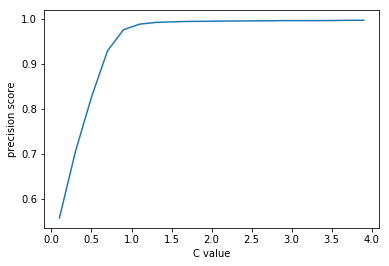

In [34]:
# Takes around 20-30 minutes without the feature selection part
# Takes a couple of miniutes after the feature selection

KERNEL = 'linear'
C_start = 0.1
C_end = 4.0
C_inc = 0.20

C_values, precision_scores = [], []

C_val = C_start
best_precision_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    svc_model_loop = SVC(C=C_val, kernel=KERNEL, random_state=42)
    svc_model_loop.fit(features, labels.ravel())
    svc_predict_loop_test = svc_model_loop.predict(features)
    
    precision_score = metrics.precision_score(labels, svc_predict_loop_test, average='micro')
    precision_scores.append(precision_score)
    if (precision_score > best_precision_score):
        best_precision_score = precision_score
        best_lr_predict_test = svc_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[precision_scores.index(best_precision_score)]
print("Max value of {0:.3f} occured at C={1:.3f}".format(best_precision_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, precision_scores, "-")
plt.xlabel("C value")
plt.ylabel("precision score")

In [35]:
# best_score_C_val = 1.300
KERNEL = 'linear'
classifier = SVC(kernel=KERNEL, C=best_score_C_val)
classifier.fit(features, labels)

SVC(C=3.9000000000000012, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Prediction on training data

In [36]:
from sklearn import metrics

nb_predict_train = classifier.predict(features)
#check accuracy
print("Accuracy: {:0.4f}".format(metrics.accuracy_score(labels, nb_predict_train)))
del features

Accuracy: 0.9971


In [37]:
#print confusion matrix
print("{}".format(metrics.confusion_matrix(labels, nb_predict_train, labels=[1,-1, 0])))

print("{}".format(metrics.classification_report(labels, nb_predict_train, labels=[1, -1, 0])))

[[2681    1   10]
 [   2 1015    7]
 [   1    0 3488]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2692
         -1       1.00      0.99      1.00      1024
          0       1.00      1.00      1.00      3489

avg / total       1.00      1.00      1.00      7205



### Predict using the model
***

#### Import test data

In [59]:
t_df = pd.read_csv('./data/test/actual/test_B_labeled.tsv', sep='\t', header=None)
t_df.shape

(8902, 4)

In [60]:
t_df = t_df[t_df[3] != 'Not Available']
t_df.shape

(7584, 4)

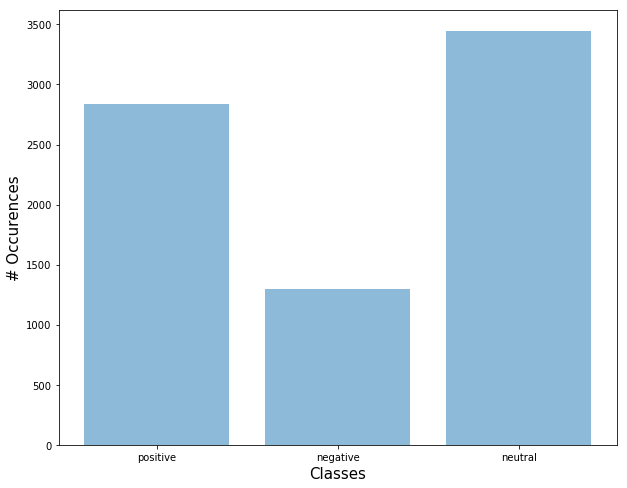

In [61]:
# The bar chart for the test data set

y = [len(t_df[t_df[2] == i]) for i in ['positive', 'negative', 'neutral']]
x = ['positive', 'negative', 'neutral']
x_pos = range(len(x))

plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('# Occurences').set_size(15)
plt.xlabel('Classes').set_size(15)

#### Pre-process tweets from the test dataset

In [62]:
raw_tweets_test = t_df[3]
raw_tweets_test = [subsEmoticon(tweet, emoticon_dict) for tweet in raw_tweets_test]
raw_tweets_test = [replaceSlangs(tweet, slangs) for tweet in raw_tweets_test]
raw_tweets_test = [replace_apostrophe(tweet, apos) for tweet in raw_tweets_test]
raw_tweets_test = [handle_negation(tweet) for tweet in raw_tweets_test]
preprocessed_tweets_test = [preprocess(tweet) for tweet in raw_tweets_test]
final_tweets_test = [rem_stop(tweet) for tweet in preprocessed_tweets_test]
t_df[3] = final_tweets_test

del raw_tweets_test, preprocessed_tweets_test

In [63]:
t_raw_tweets_MPQA = [subsMPQA(tweet,dictionary) for tweet in final_tweets_test]
t_raw_tweets_bing = [subsBINGP(tweet, expanded_pos) for tweet in t_raw_tweets_MPQA]
t_raw_tweets_bing = [subsBINGN(tweet, expanded_neg) for tweet in t_raw_tweets_MPQA]

t_BingMpqaScore = []
t_AfinnScore, t_AfinnReps = [], []
t_WordnetScore, t_WordnetReps = [], []
t_SemEvalScore, t_SemEvalReps = [], []
t_length = len(t_raw_tweets_bing)

for tw in t_raw_tweets_bing:
    Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
            Bing_MPQA +=  1
        if (i == 'negative'):
            Bing_MPQA -= 1
    t_BingMpqaScore.append(Bing_MPQA)
    tmp = afinnPolarity(tw, afinn)
    t_AfinnScore.append(tmp[0])
    t_AfinnReps.append(tmp[1])
    tmp = WordnetPolarity(tw, sentiWordnet)
    t_WordnetScore.append(tmp[0])
    t_WordnetReps.append(tmp[1])
    tmp = SemEvalLexiconPolarity(tw, EnglishLexicon)
    t_SemEvalScore.append(tmp[0])
    t_SemEvalReps.append(tmp[1])

    
#reshape
t_BingMpqaScore = np.array(t_BingMpqaScore).reshape(t_length, 1)
t_AfinnScore = np.array(t_AfinnScore).reshape(t_length, 1)
t_AfinnReps = np.array(t_AfinnReps).reshape(t_length, 1)
t_WordnetScore = np.array(t_WordnetScore).reshape(t_length, 1)
t_WordnetReps = np.array(t_WordnetReps).reshape(t_length, 1)
t_SemEvalScore = np.array(t_SemEvalScore).reshape(t_length, 1)
t_SemEvalReps = np.array(t_SemEvalReps).reshape(t_length, 1)

#Normalization
t_BingMpqaScore = t_BingMpqaScore/np.linalg.norm(t_BingMpqaScore)
t_AfinnScore = t_AfinnScore/np.linalg.norm(t_AfinnScore)
t_AfinnReps = t_AfinnReps/np.linalg.norm(t_AfinnReps)
t_WordnetScore = t_WordnetScore/np.linalg.norm(t_WordnetScore)
t_WordnetReps = t_WordnetReps/np.linalg.norm(t_WordnetReps)
t_SemEvalScore = t_SemEvalScore/np.linalg.norm(t_SemEvalScore)
t_SemEvalReps = t_SemEvalReps/np.linalg.norm(t_SemEvalReps)


t_total = np.hstack( (t_BingMpqaScore, t_AfinnScore, t_WordnetScore, t_SemEvalScore) )
t_final = np.sum(t_total, axis=1).reshape(t_length, 1)
print (t_total.shape)

# Delete
del t_raw_tweets_MPQA, t_raw_tweets_bing

(7584, 4)


In [64]:
t_df.head()

,0,1,2,3
2,282031301962395648,T14111200,neutral,dec st know end_not world_not Baby_not Boom_no...
3,11975,SM112166,negative,Yar quite clever aft many guesses lor got ask ...
4,136592,LJ112295,negative,Yeah Thin Lizzy HATE informercials
5,253421252956545024,T13114433,neutral,MT #Syria Deir Ezzor Ali Bashar altheeb martyr...
6,220880422320603137,T14114138,negative,hate life see_not roskilde_not festival_not sa...


#### Create the features vector

In [65]:
test_features = count_vectorizer.transform(final_tweets_test)
test_count_features = svd.transform(test_features)
test_count_features = scipy.sparse.csr_matrix(test_count_features)
print (count_features.shape)


test_features = tfidf_vectorizer.transform(final_tweets_test)
test_features.shape

ValueError: dimension mismatch

In [ ]:
t_final_total = scipy.sparse.csr_matrix(np.hstack( (t_total, t_final, t_AfinnReps, t_WordnetReps, t_SemEvalReps) ))
print (t_final_total.shape)
test_features = scipy.sparse.hstack([test_count_features, test_features, t_final_total])
del t_total, t_final, t_final_total, t_BingMpqaScore, t_AfinnScore, t_WordnetScore, t_SemEvalScore
del t_AfinnReps, t_WordnetReps, t_SemEvalReps

#### Get labels from a set of test data

In [ ]:
actual_labels = t_df[2]
actual_labels = actual_labels.map(mapper)
actual_labels.shape

#### Predict labels using the template

In [ ]:
predicted_labels = classifier.predict(test_features)

### Evaluate the Model
***

#### Evaluate the accuracy

In [ ]:
print('Accuracy: {:0.2f}%'.format(metrics.accuracy_score(actual_labels, predicted_labels) * 100))

#### Accuracy of cross-validation 10 times on test data

In [ ]:
# from sklearn import model_selection

# scores = model_selection.cross_val_score(classifier, test_features, actual_labels, cv=10, scoring='accuracy')
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# del test_features

In [ ]:
# draw the classification report
print('{}'.format(metrics.classification_report(actual_labels, predicted_labels)))

See [Confusion Matrix](https://fr.wikipedia.org/wiki/Matrice_de_confusion) for more details


In [ ]:
# Confusion Matrix
print('{}\n'.format(metrics.confusion_matrix(actual_labels, predicted_labels, labels=[1,-1,0])))
print("\x1b[31m\" macro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" micro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='micro')))

### Comparison with the 5 best teams of subtask B

We compare our average f-score with the other teams in the workshop. The results are taken from the attached document:
[Final report SemEval 2014 Subtask 9](http://www.aclweb.org/anthology/S14-2009)

|Team|Accuracy (Macro Averaged)| Accuracy (Micro Averaged)|
|----|-------------------------|--------------------------|
|TeamX|65.63%|69.99%|
|coooolll|63.23%|70.51%|
|RTRGO|63.08%|70.15%|
|NRC-Canada|67.62%|71.37%|
|TUGAS|63.89%|68.84%|
|**_ME_**|_57.48%_|_64.86%_|
| | |***classement : 23 / 50***|
 